In [1]:
# some helper functions
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import mean_absolute_error

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

def plot_scatter(falling_times, c="royalblue"):
    plt.scatter(falling_times["height"], falling_times["duration"], c=c)
    plt.xlabel("height (m)")
    plt.ylabel("time (s)")
    plt.ylim(-0.1, 1.1)
    
def fit_model_with_complexity(data, complexity, degree=3):
    """Fit a spline to the data - basically a wiggly line that fits as many points as possible."""
    pipe = make_pipeline(SplineTransformer(complexity, degree), LinearRegression())
    pipe.fit(data[["height"]], data["duration"])
    return pipe

def predict_model(pipe):
    interpolation = pd.DataFrame(
        {
            "height": np.linspace(0, 5, 201)
        }
    )
    interpolation["prediction"] = pipe.predict(interpolation)
    return interpolation

def calculate_error(pipe, data):
    predictions = pipe.predict(data[["height"]])
    return mean_absolute_error(predictions, data["duration"])

def plot_interpolation(data, complexity):
    pipe = fit_model_with_complexity(data, complexity)
    interpolation = predict_model(pipe)
    error = calculate_error(pipe, data)
    plt.plot(interpolation["height"], interpolation["prediction"], color="darkorange")
    plt.ylim(-0.1, 1.1)
    plt.title(f"Mean Absolute Error: {error:.3f}")

# Train and Test Sets
Now we will look at another important concept: Train and Test Sets. 

## Falling-Time Calculation

Consider again the example of the ball falling time. The data (still) looks like this:


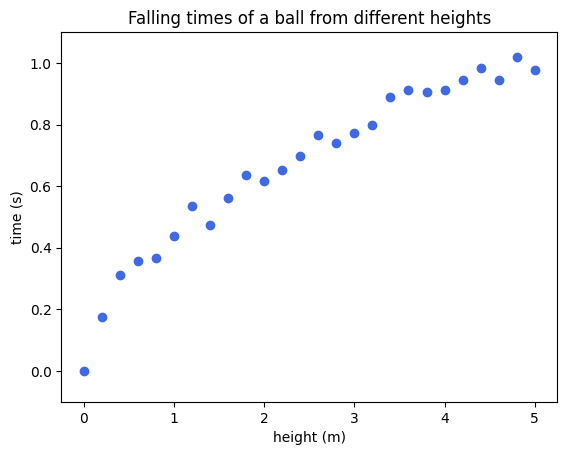

In [3]:
falling_times = pd.read_csv("../data/ball_falling_time.csv")
plot_scatter(falling_times)
plt.title("Falling times of a ball from different heights");


### The problem with our current approach
We could achieve a perfect fit by learning by heart all data points (i.e. an error of 0). Such a model may look like this:

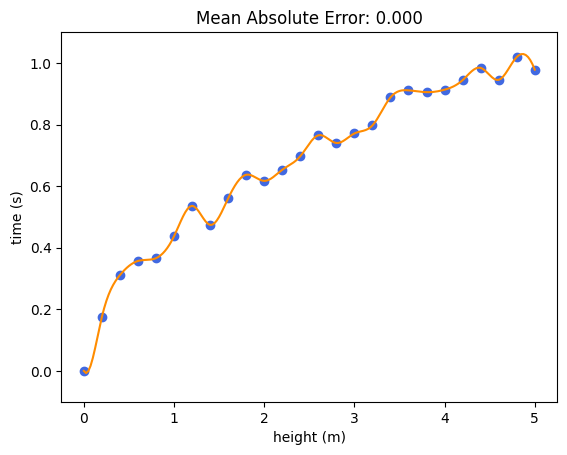

In [4]:
plot_scatter(falling_times)
plot_interpolation(falling_times, 26)


However, this model is clearly wrong: If we increase the height, we should *always* have a longer falling time. The orange curve therefore should never go down.

**This example shows that the metric we have been calculating until now is not appropriate to measure model quality.**

### The Solution: Splitting into Training and Testing Set

The solution to this problem is quite easy: Before fitting our model, we split our data set randomly in a **train set** and a **test set**. During model fitting, we will only show the model the data points in the train set. When we evaluate our model by calculating the performance metric, we will do this on the test set. This way, we test the model on data points that it has not seen during training.

Let's split the data:

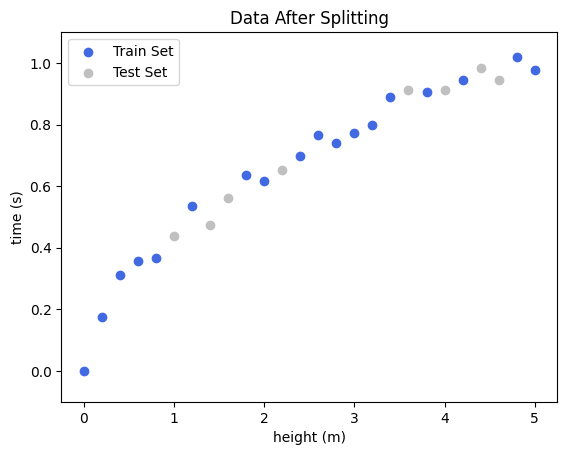

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
    falling_times,
    train_size=.7,  # we randomly choose 70% of our data points for training, the remaining will be test data
    random_state=123,  # set the seed to ensure reproducibility
)

plot_scatter(train)
plot_scatter(test, c="silver")

plt.title("Data After Splitting")
plt.legend(["Train Set", "Test Set"]);


Now, if we train the same model as before, we will get the following results:

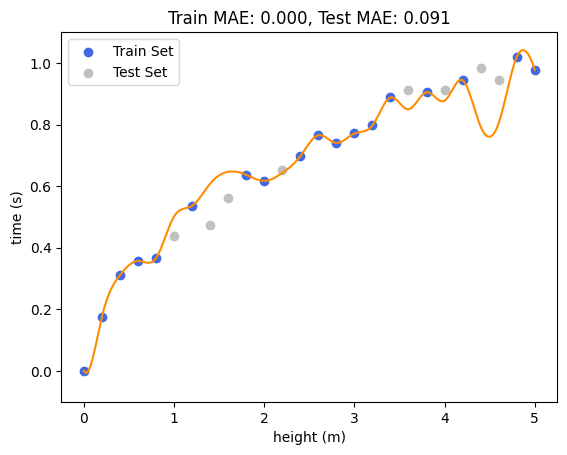

In [6]:
def plot_interpolation_split(train, test, complexity):
    pipe = fit_model_with_complexity(train, complexity)
    interpolation = predict_model(pipe)
    train_error = calculate_error(pipe, train)
    test_error = calculate_error(pipe, test)
    plt.plot(interpolation["height"], interpolation["prediction"], color="darkorange")
    plt.ylim(-0.1, 1.1)
    plt.title(f"Train MAE: {train_error:.3f}, Test MAE: {test_error:.3f}")


plot_scatter(train)
plot_scatter(test, c="silver")
plot_interpolation_split(train, test, 26)
plt.legend(["Train Set", "Test Set"]);


We see that our model still perfectly learns the blue dots by heart, but performs quite badly on the grey points that it hasn't seen during training. The error on the train set is still 0, but on the test set the model has a mean absolute error of 0.091. 

This case, where our model performs extremly well on the training set but poorly on the test set is called **overfitting**. Another way to say this is that the model does not **generalize** well - it just reproduces what is has learned by heart.

### Underfitting

If on the other hand we have a model that isn't flexible enough to fit the data, we have **underfitting**. 

In our toy model, we have a parameter "complexity" that controls how flexible our model is. Play with this parameter to see how this affects the model, the train and the test error. For which value of complexity do we get the best fit?

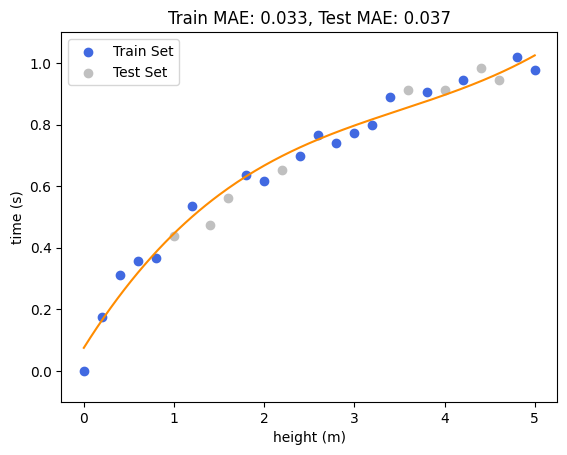

In [7]:
# CHANGE THIS (value must be an integer >= 2)
complexity = 2

# don't change
plot_scatter(train)
plot_scatter(test, c="silver")
plot_interpolation_split(train, test, complexity)
plt.legend(["Train Set", "Test Set"]);


### Train and Test Error vs. Complexity
If we keep increasing the complexity and record the train and test errors on our dataset, we obtain the following image:

Text(0.5, 1.0, 'Under- and Overfitting')

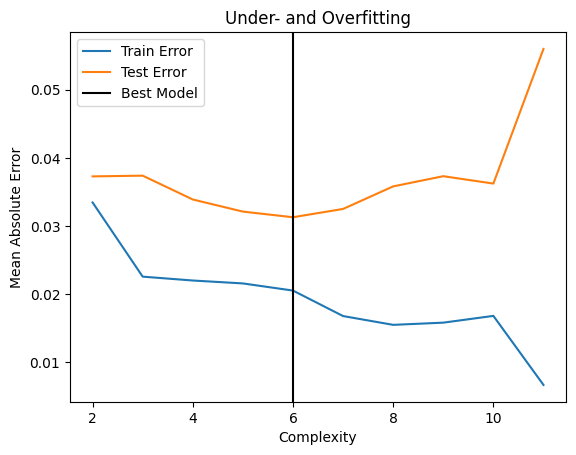

In [8]:
# Calculate errors for different values of complexity
errors = []
for complexity in range(2, 12):
    pipe = fit_model_with_complexity(train, complexity)

    train_error = calculate_error(pipe, train)
    test_error = calculate_error(pipe, test)
    errors.append(
        {
            "complexity": complexity,
            "train_error": train_error,
            "test_error": test_error,
        }
    )

errors_df = pd.DataFrame(errors)

# Create the plot
plt.plot(errors_df["complexity"], errors_df["train_error"])
plt.plot(errors_df["complexity"], errors_df["test_error"])
plt.axvline(errors_df["complexity"].loc[errors_df["test_error"].argmin()], color="k")

plt.legend(["Train Error", "Test Error", "Best Model"])
plt.xlabel("Complexity")
plt.ylabel("Mean Absolute Error")

plt.title("Under- and Overfitting")

The picture above shows the evolution of the train and test errors, depending on the complexity. The best model for our data has complexity 6. All models to the left of the black line (with complexity less than 6) aren't flexible enough in order to fit the data - and are thus *underfitting* the data. All models to the right of the black line (with complexity more than 6) are too flexible and learn the training data by heart. These models are *overfitting* the data.

## Life Expectancy Data

The same problem exists on our life expectancy data: A model could just learn by heart all of the data points to get a low training error, but will perform poorly on new data. 

If we stick to linear regression, we do not have a specific parameter that governs complexity. Instead, the complexity is given by the number of features that we provide to the model: By adding more features, the model becomes more flexible.

In [19]:
life_expectancy = pd.read_csv("../data/who_data.csv", index_col=0)

# filter missing values
has_missing_values = life_expectancy.isna().sum(axis=1) == 0
life_expectancy = life_expectancy[has_missing_values]

# create the features that we had
life_expectancy["log_GDP_per_capita"] = np.log10(life_expectancy["GDP"] / life_expectancy["population"])
life_expectancy["log_CHE"] = np.log10(life_expectancy["CHE"])

# split into train and test data
train, test = train_test_split(life_expectancy, train_size=.7, random_state=12)

# define function that calculates errors for us
def fit_and_calculate_errors(train, test, feature_list):
    regression = LinearRegression()
    regression.fit(train[feature_list], train["life_expectancy"])

    train_error = mean_absolute_error(
        train["life_expectancy"],
        regression.predict(train[feature_list])
    )
    test_error = mean_absolute_error(
        test["life_expectancy"],
        regression.predict(test[feature_list])
    )

    return {
        "train_error": train_error,
        "test_error": test_error,
    }


Let's train a model only on the log-transformed GDP per capita.

In [20]:
fit_and_calculate_errors(train, test, ["log_GDP_per_capita"])

{'train_error': 3.0628802818834373, 'test_error': 3.125822527576768}

How do we perform if we add the log-transformed CHE-data?

In [11]:
fit_and_calculate_errors(train, test, ["log_GDP_per_capita", "log_CHE"])

{'train_error': 2.9575283412185827, 'test_error': 2.972642126314154}

We see that we improved both in the train and the test error. This means that only using the GDP was underfitting the data. Now let's add the prevalence of underweight adults:

In [12]:
fit_and_calculate_errors(train, test, ["log_GDP_per_capita", "log_CHE", "prevalence_underweight"])

{'train_error': 2.9484507497032357, 'test_error': 3.1011201095585412}

In [16]:
fit_and_calculate_errors(train, test, ['population', 'GDP', 'pol3', 'dpt3',
       'prevalence_obesity', 'fine_particular_matter', 'hepB',
       'CHE', 'prevalence_underweight',
       'alcohol_consumption', 'log_GDP_per_capita', 'log_CHE']
)

{'train_error': 2.6224438057942825, 'test_error': 3.0717705016653643}

Now the train error decreased even more, but the test error increased. This means that we are now overfitting the data.

### Exercise
Write down a definition for the following terms:

- **training set**
- **test set**
- **underfitting**
- **overfitting**
- **generalization**

### Exercise
Try out the combinations of features that worked best for you in the previous notebook. 
- Could you improve performance on the test set, or were you overfitting? 
- Can you find a combination of features that further decreases the test error?